In [1]:
import xarray as xr
import numpy as np
import datetime
from scipy.ndimage import gaussian_filter

from meteoSI import mod_ad

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from PlottingUtility import load_cbar_style, load_xy_style
from Utils import find_bases_tops
import Colormaps

_FIG_SIZE = (14, 4.7)

font_settings = {
    'range_interval': [0, 6000],
    'fig_size': [15, 10],
    'rg_converter': True,
    'font_size': 15,
    'font_weight': 'normal',
    'zlabel': '',
}


# trained on >100 epochs of 60/600 (20181127-20190927)
voodoo_nc = '20190801-20190801-20201017-174440__20201017-174440_weights_compressed.h5.nc'
#voodoo_nc = '20190313-20190313-20201017-174440__20201017-174440_weights_compressed.h5.nc'
case = voodoo_nc[:8]
YYYY, MM, DD = int(case[:4]), int(case[4:6]), int(case[6:8])

In [2]:
# open the dataset using xarray
voodoo_xr = xr.open_mfdataset(f'data/{voodoo_nc}')

# convert to datetime
dt_list = [datetime.datetime.fromtimestamp(ts) for ts in voodoo_xr.ts.values]
print(voodoo_xr)


# look at important classes "ice", "ice and supercooled droplets", "cloud droplets only", and "drizzle/rain"
P_mixed = voodoo_xr['voodoo_classification_probabilities'][:, :, 5].copy()
P_droplets = voodoo_xr['voodoo_classification_probabilities'][:, :, 1].copy()

# all classes containing cloud droplets
P_allCD = P_droplets.copy()
P_allCD.values = P_mixed.values + P_droplets.values

<xarray.Dataset>
Dimensions:                              (cl: 9, rg: 292, ts: 1081)
Coordinates:
  * ts                                   (ts) float64 1.565e+09 ... 1.565e+09
  * rg                                   (rg) float64 119.2 149.1 ... 1.196e+04
  * cl                                   (cl) int64 0 1 2 3 4 5 6 7 8
    temperature                          (ts, rg) float64 dask.array<shape=(1081, 292), chunksize=(1081, 292)>
    pressure                             (ts, rg) float64 dask.array<shape=(1081, 292), chunksize=(1081, 292)>
    relhumidity                          (ts, rg) float64 dask.array<shape=(1081, 292), chunksize=(1081, 292)>
    target_classification                (ts, rg) int32 dask.array<shape=(1081, 292), chunksize=(1081, 292)>
    voodoo_classification                (ts, rg) float32 dask.array<shape=(1081, 292), chunksize=(1081, 292)>
    detection_status                     (ts, rg) int32 dask.array<shape=(1081, 292), chunksize=(1081, 292)>
    mask    

# Smooth the predictions using a Gaussian filter

In [3]:
P_allCD.values = gaussian_filter(P_allCD.values, sigma=1.0)

# calculate adiabatic liquid water path from temperature and pressure profiles\n",

Calculate  liquid water path for cloud droplet containing pixel, if $P(\hat{y}=1 \wedge \hat{y}=5) > 0.7$, for a prediction $\hat{y} = \mathrm{voodoo}(\mathrm{X})$
   

In [4]:
def calc_adLWP(liquid_mask, temperature, pressure, relhumidity, rg):

    bt_lists, bt_mask = find_bases_tops(liquid_mask, rg)
    adLWP = np.zeros(liquid_mask.shape[0])

    for iT in range(liquid_mask.shape[0]):
        
        n_cloud_layers = len(bt_lists[iT]['idx_cb'])
        if n_cloud_layers < 1: continue

        lwc = 0
        for iL in range(n_cloud_layers):
            tmp_idx = np.arange(bt_lists[iT]['idx_cb'][iL], bt_lists[iT]['idx_ct'][iL], dtype=np.int)
            if tmp_idx.size > 1:  # exclude single range gate clouds
                # calculates adiabatic lwc
                lwc += np.sum(mod_ad(temperature[iT, tmp_idx], pressure[iT, tmp_idx], relhumidity[iT, tmp_idx], rg[tmp_idx]))   # kg/m3

        #adLWP[iT] = np.sum(lwc)    # kg/m3 --> g/m3
        adLWP[iT] = lwc*1000    # kg/m3 --> g/m3


    return adLWP


In [11]:
algos = ['voodoo', 'cloudnet', 'voodoo_post']

from Utils import postprocessor
voodoo_xr['voodoo_classification_post'] = postprocessor(voodoo_xr)

liquid_probability_threshold = 0.7
liquid_mask = {
    'voodoo': P_allCD.values > liquid_probability_threshold,
    'cloudnet': (voodoo_xr.target_classification.values == 1) + (voodoo_xr.target_classification.values == 3) \
                + (voodoo_xr.target_classification.values == 5),#  + (voodoo_xr.target_classification.values == 7),
    'voodoo_post': (voodoo_xr.voodoo_classification_post.values == 1) + (voodoo_xr.voodoo_classification_post.values == 3) \
                + (voodoo_xr.voodoo_classification_post.values == 5)# + (voodoo_xr.voodoo_classification_post.values == 7)
}

adiabatic_lwp = {
    alg: calc_adLWP(
        liquid_mask[alg], 
        voodoo_xr.temperature.values, 
        voodoo_xr.pressure.values, 
        voodoo_xr.relhumidity.values/100., 
        voodoo_xr.rg.values) for alg in algos
}
bases_tops    = {alg: find_bases_tops(liquid_mask[alg], voodoo_xr.rg.values) for alg in algos}


/Users/willi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


In [12]:
#print(voodoo_xr.relhumidity.values)

In [13]:
def get_bases(bases_tops):
    dt_s, rg_s, dt1base, rg1base = [], [], [], []
    for i in range(len(bases_tops[0])):
        for j in range(bases_tops[0][i]['idx_cb'].size):
            if bases_tops[0][i]['width'][j] > 150.:
                dt_s.append(dt_list[i])
                rg_s.append(bases_tops[0][i]['val_cb'][j]/1000.)
                if j == 0: 
                    dt1base.append(dt_list[i])
                    rg1base.append(bases_tops[0][i]['val_cb'][0]/1000.)
    return {'all': [dt_s, rg_s], 'first': [dt1base, rg1base]}

bases = {alg: get_bases(bases_tops[alg]) for alg in algos}

# plot adiabatic lwp / MWR lwp and probability for cloud droplets



smooth 20 time steps or 600 [sec]


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


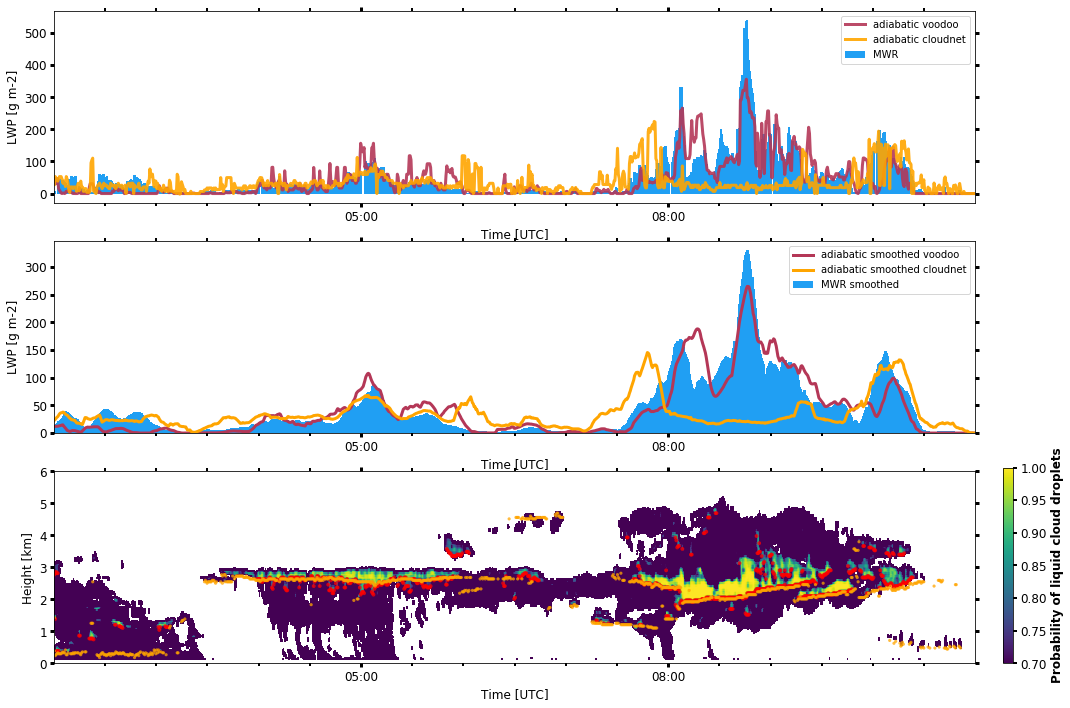

In [14]:
box_pts = 20
print(f'smooth {box_pts} time steps or {box_pts*30} [sec]')

box = np.ones(box_pts) / box_pts
adiabatic_lwp['mwr'] = voodoo_xr.lwp.values
adiabatic_lwp['mwr_s'] = np.convolve(voodoo_xr.lwp.values, box, mode='same')
adiabatic_lwp['voodoo_s'] = np.convolve(adiabatic_lwp['voodoo'], box, mode='same')
adiabatic_lwp['voodoo_post_s'] = np.convolve(adiabatic_lwp['voodoo_post'], box, mode='same')
adiabatic_lwp['cloudnet_s'] = np.convolve(adiabatic_lwp['cloudnet'], box, mode='same')

idk_factor = 4
lw = 3.0


fig, ax = plt.subplots(nrows=3, figsize=(20, 12))
line = ax[0].plot(dt_list, adiabatic_lwp['voodoo']*idk_factor, color=Colormaps.cloudnet_colors[10], linewidth=lw, alpha=0.9, label='adiabatic voodoo')
line = ax[0].plot(dt_list, adiabatic_lwp['cloudnet']*idk_factor, color=Colormaps.cloudnet_colors[6], linewidth=lw, alpha=0.9, label='adiabatic cloudnet')
#line = ax[0].plot(dt_list, adiabatic_lwp['voodoo_post']*idk_factor, color=Colormaps.cloudnet_colors[7], linewidth=lw, alpha=0.9, label='adiabatic voodoo_post')
line = ax[0].bar(dt_list, adiabatic_lwp['mwr'], width=0.001, color=Colormaps.cloudnet_colors[2], label='MWR')
load_xy_style(ax[0], ylabel='LWP [g m-2]')
ax[0].set_xlim([dt_list[0], dt_list[-1]])
ax[0].legend()

line = ax[1].plot(dt_list, adiabatic_lwp['voodoo_s']*idk_factor, color=Colormaps.cloudnet_colors[10], linewidth=lw, label='adiabatic smoothed voodoo')
line = ax[1].plot(dt_list, adiabatic_lwp['cloudnet_s']*idk_factor, color=Colormaps.cloudnet_colors[6], linewidth=lw, label='adiabatic smoothed cloudnet')
#line = ax[1].plot(dt_list, adiabatic_lwp['voodoo_post_s']*idk_factor, color=Colormaps.cloudnet_colors[7], linewidth=lw, alpha=0.9, label='adiabatic
# voodoo_post')
line = ax[1].bar(dt_list, adiabatic_lwp['mwr_s'], width=0.001, color=Colormaps.cloudnet_colors[2], label='MWR smoothed')
load_xy_style(ax[1], ylabel='LWP [g m-2]')
ax[1].set_xlim([dt_list[0], dt_list[-1]])
ax[1].legend()

P_allCD.values = np.ma.masked_where(voodoo_xr.mask, P_allCD)
pmesh = ax[2].pcolormesh(dt_list, voodoo_xr.rg.values/1000., P_allCD.values.T, cmap='viridis', vmin=liquid_probability_threshold, vmax=1)
cbar = fig.colorbar(pmesh, ax=ax, pad=0.025, shrink=0.3, anchor=(0.0, 0.0))
ax[2].set_ylim([0, 6])
ax[2].set_xlim([dt_list[0], dt_list[-1]])
load_xy_style(ax[2], ylabel='Height [km]')
load_cbar_style(cbar, cbar_label='Probability of liquid cloud droplets')
ax[2].scatter(bases['voodoo']['all'][0], bases['voodoo']['all'][1], c='red', s=15, alpha=0.75, edgecolor='none')
ax[2].scatter(bases['cloudnet']['all'][0], bases['cloudnet']['all'][1], c=Colormaps.cloudnet_colors[6], s=10, alpha=0.75, edgecolor='none')
fig.savefig(f'plots/{case}-liquid-cloud-doplet-probability.png', dpi=450)


In [15]:

from Utils import get_cloud_base_from_liquid_mask, corr_

cb_v = get_cloud_base_from_liquid_mask(liquid_mask['voodoo'], voodoo_xr.rg.values)
cb_c = get_cloud_base_from_liquid_mask(liquid_mask['cloudnet'], voodoo_xr.rg.values)

joint_availability = (cb_v > 0.0) * (cb_c > 0.0)

print(f'correlation ceilometer cbh vs voodoo cbh =  {corr_(cb_v[joint_availability], cb_c[joint_availability]):.2f}')


correlation ceilometer cbh vs voodoo cbh =  0.72


In [16]:
import pandas as pd
from Utils import corr_

correlation = [[corr_(adiabatic_lwp['mwr'], adiabatic_lwp['voodoo']),   corr_(adiabatic_lwp['mwr_s'], adiabatic_lwp['voodoo_s'])],
               [corr_(adiabatic_lwp['mwr'], adiabatic_lwp['cloudnet']), corr_(adiabatic_lwp['mwr_s'], adiabatic_lwp['cloudnet_s'])],
               [corr_(adiabatic_lwp['mwr'], adiabatic_lwp['voodoo_post']), corr_(adiabatic_lwp['mwr_s'], adiabatic_lwp['voodoo_post_s'])]]

df_corr = pd.DataFrame(correlation, columns = ['lwp_raw_corr' , 'lwp_smoothed_corr'], index=['voodoo', 'cloudnet', 'voodoo_post'])

print('Correlation MWR-LWP with adiabatic LWP from liquid pixel mask\n')
print(df_corr)

print(f'\nmaximum liquid water path value = {adiabatic_lwp["voodoo"].max():.2f} [g m-2]') 


Correlation MWR-LWP with adiabatic LWP from liquid pixel mask

             lwp_raw_corr  lwp_smoothed_corr
voodoo           0.791386           0.890960
cloudnet         0.109858           0.236762
voodoo_post      0.737712           0.869186

maximum liquid water path value = 89.09 [g m-2]
